# Get metrics and Plot

In [3]:
import matplotlib.pyplot as plt
from train import *

In [24]:
SFNP_path = "logs/SFNP_train_seed0_lr0.000168_bs_1_Tue Feb 28 01:09:51 2023"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [317]:
class Evaluator():
    def __init__(self, dirpath):
        self.dirpath = dirpath
        self.config = yaml.safe_load(open(f"{dirpath}/saved_config.yaml"))
        self.init_dataloader()
        self.init_model()

    def init_model(self):
        self.device = torch.device('cuda')
        model_dict = torch.load(f"{self.dirpath}/best.pt", map_location=torch.device('cuda'))
        model = Model(model_dict['config']['model']).to(self.device)

        model.load_state_dict(model_dict['model'])
        model.eval()
        self.model = model

    def init_dataloader(self):
        l2_x_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/inputs_*"), key=sort_fn)
        l2_y_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/outputs_*"), key=sort_fn)

        n = int(365*0.8)
        self.l2_x_train = l2_x_data[:n]
        self.l2_y_train = l2_y_data[:n]
        self.l2_x_valid = l2_x_data[n:365]
        self.l2_y_valid = l2_y_data[n:365]
        self.l2_x_test = l2_x_data[365:]
        self.l2_y_test = l2_y_data[365:]

        l2_x_scaler_minmax = dill.load(open(f"../../scalers/x_SPCAM5_minmax_scaler.dill", 'rb'))
        l2_y_scaler_minmax = dill.load(open(f"../../scalers/y_SPCAM5_minmax_scaler.dill", 'rb'))

        # Change to first 26 variables
        l2_y_scaler_minmax.min = l2_y_scaler_minmax.min[:26]
        l2_y_scaler_minmax.max = l2_y_scaler_minmax.max[:26]

        trainset = l2Dataset(self.l2_x_train, self.l2_y_train, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
        self.trainloader = DataLoader(trainset, batch_size=self.config['batch_size'], shuffle=True, drop_last=False, \
                                        num_workers=4, pin_memory=True)
        validset = l2Dataset(self.l2_x_valid, self.l2_y_valid, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
        self.validloader = DataLoader(validset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                        num_workers=4, pin_memory=True)
        testset = l2Dataset(self.l2_x_test, self.l2_y_test, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
        self.testloader = DataLoader(testset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                    num_workers=4, pin_memory=True)

        self.l2_y_scaler_minmax = l2_y_scaler_minmax

    def get_metrics(self, loader):
        self.get_R_stats(loader)
        self.r = self.ssxym / np.sqrt(self.ssxm * self.ssym)
        return self.non_mae, self.nmae, self.r

    def forward_pass(self, data):
        with torch.no_grad():
            x, y = data

            x = x.reshape(-1, 1, x.shape[-1]).to(device)
            y = y.reshape(-1, 1, y.shape[-1]).to(device)
            context_idxs, target_idxs = split_context_target(x, self.config['context_percentage_low'], self.config['context_percentage_high'])

            x_context = x[context_idxs]
            y_context = y[context_idxs]
            x_target = x[target_idxs]
            y_target = y[target_idxs]

            with torch.cuda.amp.autocast():
                l2_output_mu, l2_output_cov, l2_z_mu_all, l2_z_cov_all, l2_z_mu_c, l2_z_cov_c = self.model(
                    x_context, y_context, x_target, x_all=x, y_all=y)

            non_y_pred = self.l2_y_scaler_minmax.inverse_transform(l2_output_mu.squeeze().cpu().numpy())
            non_y = self.l2_y_scaler_minmax.inverse_transform(y_target.squeeze().cpu().numpy())
            return non_y, non_y_pred, context_idxs, target_idxs

    def get_R_stats(self, loader):
        self._get_stats(loader)
        self.ssxm = 0
        self.ssxym = 0
        self.ssym = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                non_y, non_y_pred, _, _ = self.forward_pass(data)
                self.ssxm += ((non_y - self.y_mean)**2).sum(0)
                self.ssym += ((non_y_pred - self.y_pred_mean)**2).sum(0)
                self.ssxym += ((non_y - self.y_mean) * (non_y_pred - self.y_pred_mean)).sum(0)
            # Get average
            self.ssxm /= self.n_total
            self.ssym /= self.n_total
            self.ssxym /= self.n_total

    def _get_stats(self, loader):
        self.n_total = 0
        self.x_total = 0
        self.y_total = 0
        self.xy_total = 0
        self.x2_total = 0
        self.y2_total = 0
        self.y_mean = 0
        self.y_pred_mean = 0
        self.nmae = 0
        self.non_mae = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                non_y, non_y_pred, _, _ = self.forward_pass(data)

                non_mae = mae_metric(non_y_pred, non_y, mean=False)

                self.y_mean += non_y.sum(axis=0)
                self.y_pred_mean += non_y_pred.sum(axis=0)
                self.non_mae += non_mae.sum(axis=0)
                self.n_total += non_y.shape[0]
                self.x_total += non_y.sum(axis=0)
                self.y_total += non_y_pred.sum(axis=0)
                self.x2_total += (non_y ** 2).sum(axis=0)
                self.y2_total += (non_y_pred ** 2).sum(axis=0)
                self.xy_total += (non_y_pred * non_y).sum(axis=0)

        self.y_mean /= self.n_total
        self.y_pred_mean /= self.n_total
        self.nmae /= self.n_total
        self.non_mae /= self.n_total
        self.nmae = np.abs(np.sqrt(self.non_mae / self.n_total) / np.abs(self.y_mean))

    def plot_scenario(self, idx, split="test"):
        """
            Plots idxth day of the scenario.
        """
        if split == "test":
            loader = self.testloader
        elif split == "valid":
            loader = self.validloader
        else:
            loader = self.trainloader
        
        for i, data in enumerate(tqdm(loader, total=len(loader))):
            x, y = data

            # TODO: messed up processing from source. Fix from process_SPCAM5.py.
            y_ = y.reshape(24, 96, 144, -1)
            tl = y_[:, :48, :72, :]
            tr = y_[:, :48, 72:, :]
            bl = y_[:, 48:, :72, :]
            br = y_[:, 48:, 72:, :]

            result = torch.zeros_like(y_)
            result[:, ::2, ::2] = tl
            result[:, ::2, 1::2] = tr
            result[:, 1::2, ::2] = bl
            result[:, 1::2, 1::2] = br
            y = result

            x = x.reshape(24, -1, 1, x.shape[-1])[0]
            y = y.reshape(24, -1, 1, y.shape[-1])[0]
            non_y, non_y_pred, context_idxs, target_idxs = self.forward_pass((x, y))
            print(x.shape, y.shape)
            print(non_y.mean(), non_y_pred.mean())
            print(non_y_pred.shape)
            return non_y, non_y_pred, context_idxs, target_idxs, y

        # return self.losses


In [318]:
evaluator = Evaluator("logs/SFNP_train_seed0_lr0.000168_bs_1_Tue Feb 28 01:09:51 2023")

In [320]:
# non_y, non_y_pred, context_idxs, y = evaluator.plot_scenario(0, split="test")
non_y, non_y_pred, context_idxs, y = evaluator.plot_scenario(0, split="test")

  0%|          | 0/362 [00:00<?, ?it/s]

torch.Size([13824, 1, 108]) torch.Size([13824, 1, 26])
-4.9155174e-06 -8.1973185e-06
(9104, 26)


  0%|          | 0/362 [00:04<?, ?it/s]


In [328]:
context_idxs

array([  121, 12062,  5463, ...,  1710,  5866, 11440])

In [331]:
y_true = y.reshape(96, 144, -1)
context = np.zeros_like(y)
context[context_idxs] = non_y_pred

ValueError: shape mismatch: value array of shape (9104,26) could not be broadcast to indexing result of shape (4720,1,26)

In [322]:
context_idxs.shape

(4720,)

In [282]:
# x = np.load("inputs_2003_01_06.npy")
y = np.load("/home/mkim/Nserver/climate_processes/data/SPCAM5/outputs_2003-04-01.npy")
y_l1 = np.load("/home/mkim/Nserver/climate_processes/data/CAM5/outputs_2003-04-01.npy")

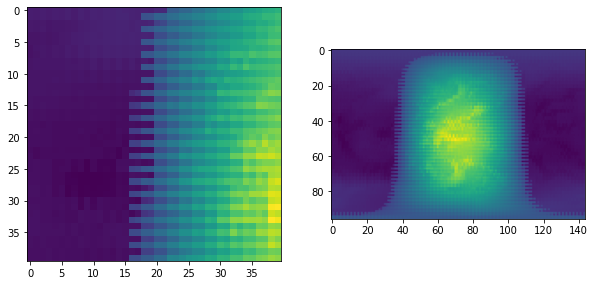

In [313]:
y_ = y.reshape(24, 96, 144, -1)
i = 0
v = 0
tl = y_[:, :48, :72, :]
tr = y_[:, :48, 72:, :]
bl = y_[:, 48:, :72, :]
br = y_[:, 48:, 72:, :]

result = np.zeros_like(y_)
result[:, ::2, ::2] = tl
result[:, ::2, 1::2] = tr
result[:, 1::2, ::2] = bl
result[:, 1::2, 1::2] = br

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(result[0, 20:60, 20:60, 0])
axs[1].imshow(result[0, :, :, 0])
# plt.imshow(result)
plt.show()

In [261]:
y_.shape

(24, 96, 144, 112)

In [262]:
y_ = y_.reshape(24, 96, 144, 112)
y_.shape

(24, 96, 144, 112)

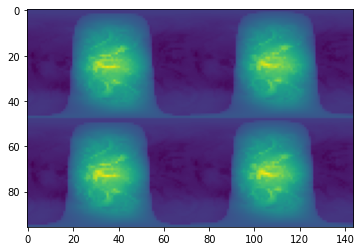

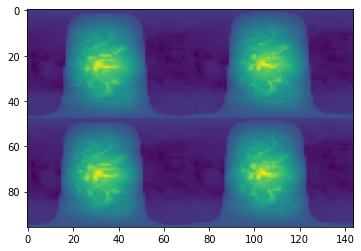

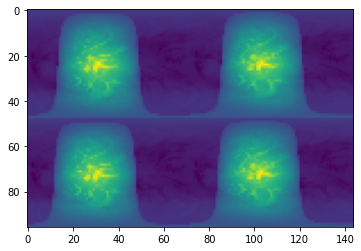

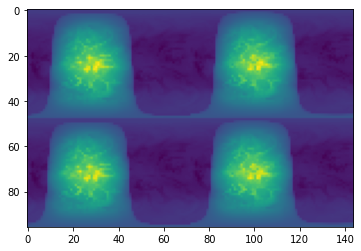

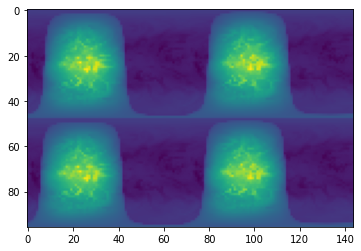

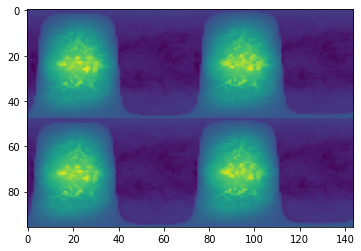

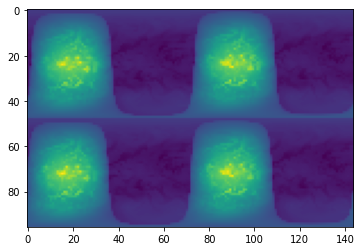

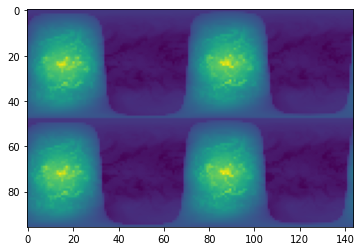

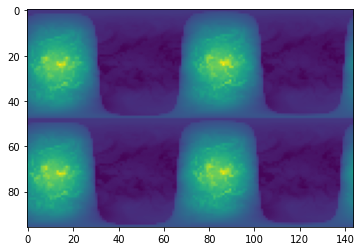

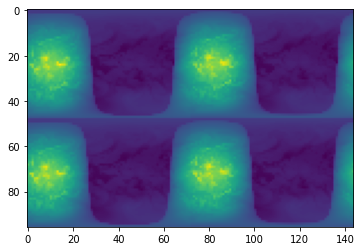

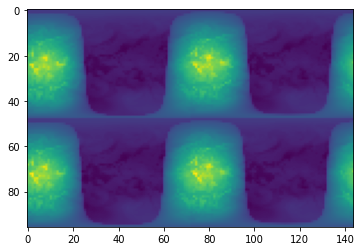

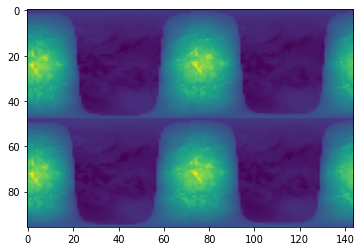

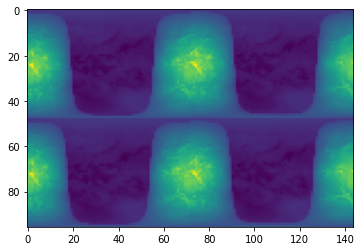

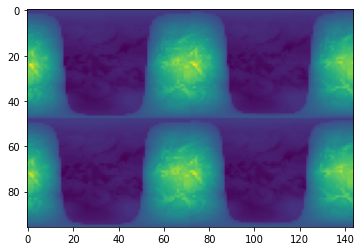

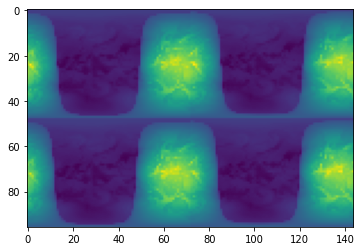

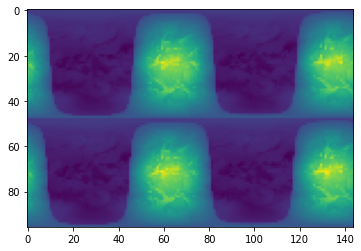

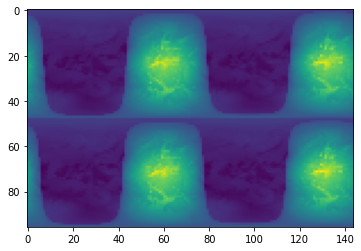

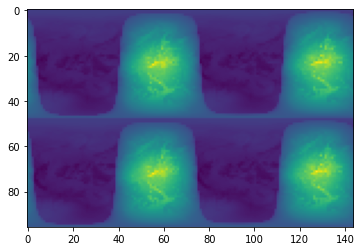

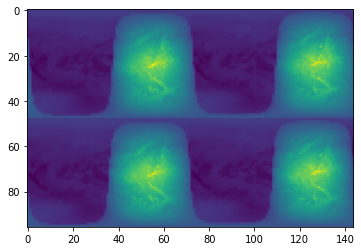

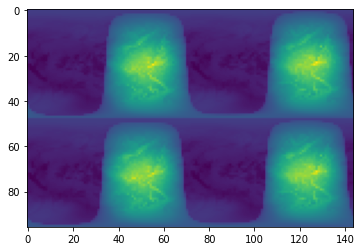

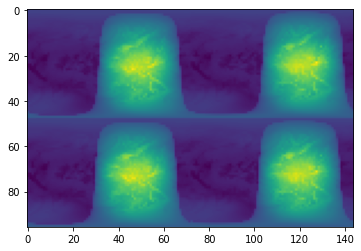

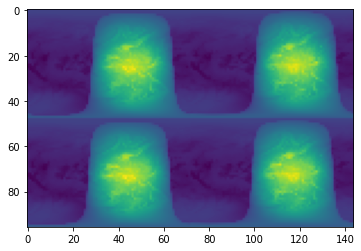

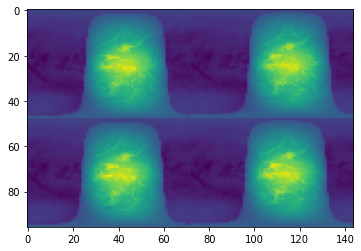

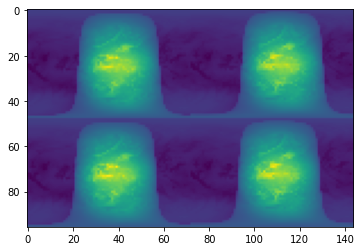

In [265]:
for i in range(24):
    plt.imshow(y_[i, :, :, 1])
    plt.show()

In [134]:
y_ = np.transpose(y.reshape(144, 24, 96, -1), (1, 2, 0, 3))[0]

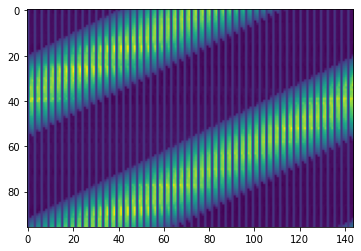

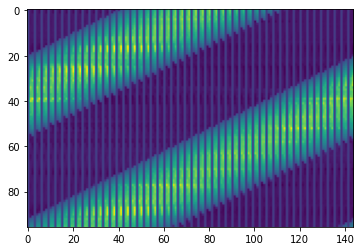

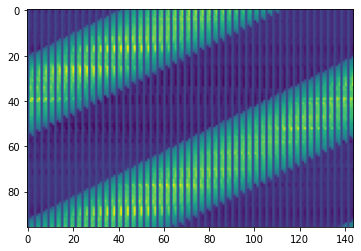

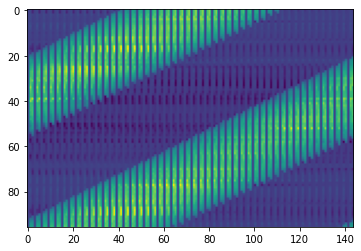

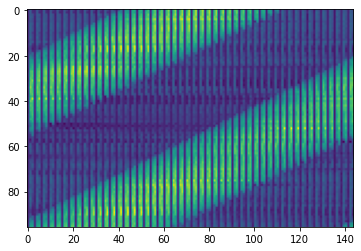

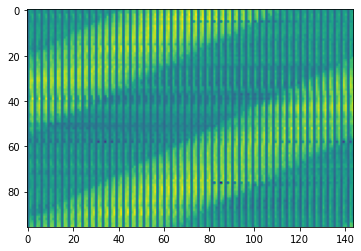

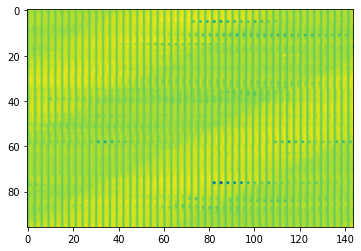

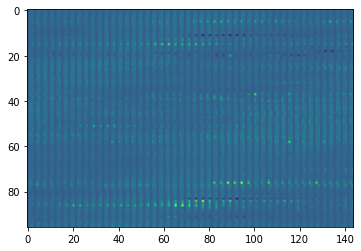

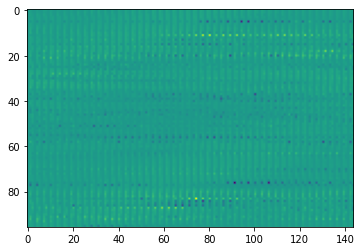

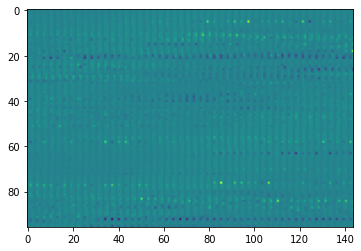

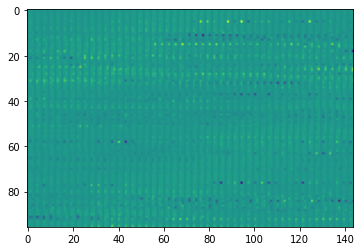

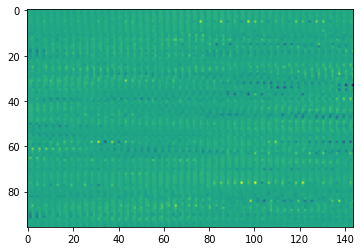

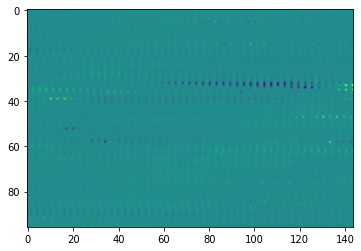

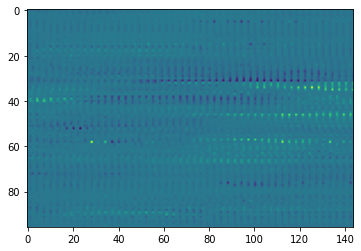

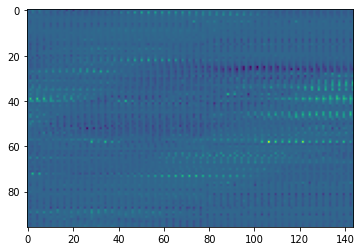

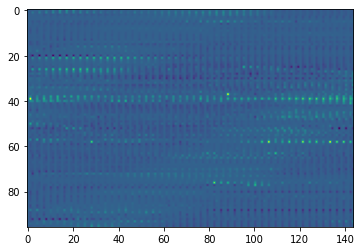

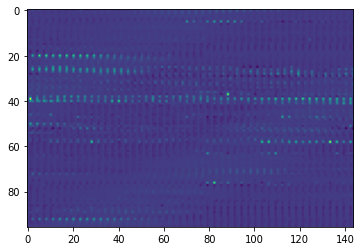

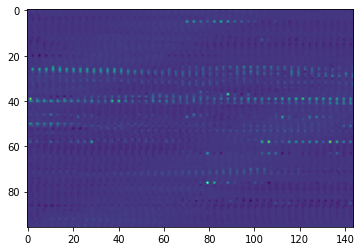

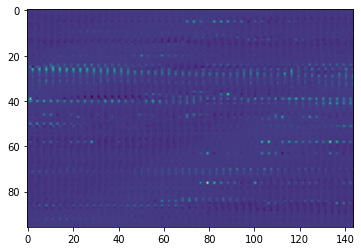

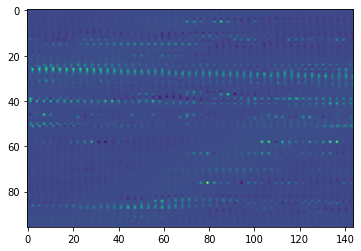

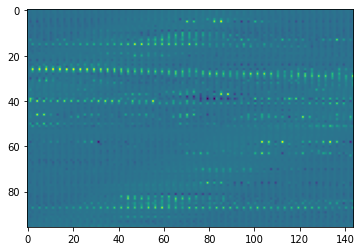

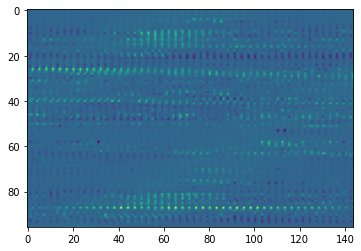

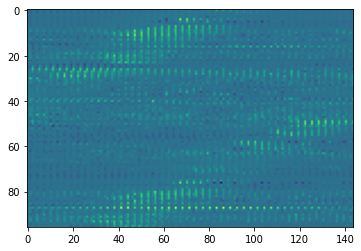

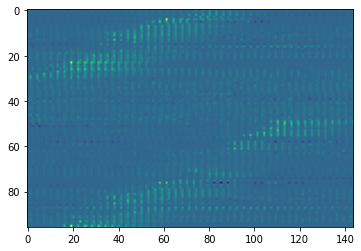

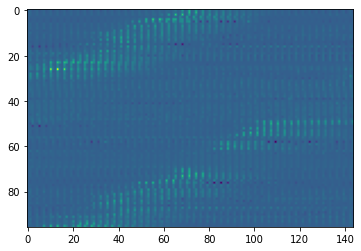

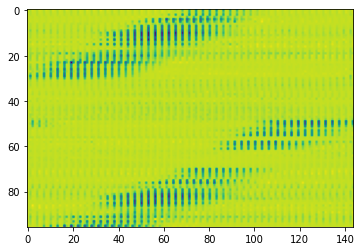

In [135]:
for i in range(26):
    plt.imshow(y_[:,:,i])
    plt.show()

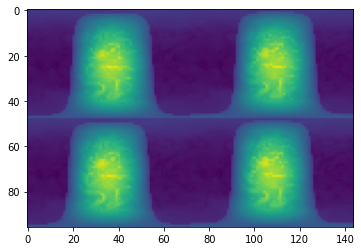

In [56]:
y_ = y.reshape(96, 144, -1)
for v in range(y.shape[-1]):
    plt.imshow(y_[:, :, v])
    plt.show()
    break